In [1]:
import importlib
import MPI_collective
import MPI
import qiskit
import math
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
importlib.reload(MPI_collective)
importlib.reload(MPI)

<module 'MPI' from '/workspaces/qmpi_cpe_kmutt/QMPI_Tinthai_Version/playground/MPI.py'>

In [2]:
# Requirement
# !pip install qiskit
# !pip install pylatexenc
# !pip install qiskit-aer

In [3]:
# Function พวกนี้ เราเขียนมาเพื่อให้ใช้งานง่ายขึ้นเฉยๆนะ

def qdata_to_circuit(qc, qdata):
    # for inst, qargs, cargs in qdata:
    #     qc.append(inst, qargs, cargs)
    for instr in qdata:
        qc.append(instr.operation, instr.qubits, instr.clbits)

def beautifule_print_result(qc, counts):
    creg_sequence = []
    for creg in qc.cregs:
        creg_sequence.append(f"{creg.name}[{creg.size}]")
    creg_sequence.reverse()
    print("Classical registers (left→right):", " → ".join(creg_sequence))

    print("\nCounts:")
    for bits, count in counts.items():
        print(f"{bits} : {count}")

def prob_single_cbit(counts, target_index):
    # index ของ cbit ตรงกลาง (จากซ้ายไปขวา)
    total = sum(counts.values())

    p0 = sum(v for k, v in counts.items() if k.split()[target_index] == '0') / total
    p1 = sum(v for k, v in counts.items() if k.split()[target_index] == '1') / total

    print(f"P(cbit[{target_index}] = 0) = {p0:.4f}")
    print(f"P(cbit[{target_index}] = 1) = {p1:.4f}")

In [4]:
# สร้าง Quantum circuit โดยเตรียมพวก Quantum register,  Classical register เอาไว้ใช้
sendqc_circuit = QuantumCircuit()
node1 = QuantumRegister(1, name = "node1")
node1_epr = QuantumRegister(2, name = "node1_epr")
node1_epr_creg = ClassicalRegister(1, name = "node1_epr_creg")
node2 = QuantumRegister(1, name = "node2")
node2_epr = QuantumRegister(2, name = "node2_epr")
node2_epr_creg = ClassicalRegister(1, name = "node2_epr_creg")
node3 = QuantumRegister(1, name = "node3")
node3_epr = QuantumRegister(1, name = "node3_epr")
node3_epr_creg = ClassicalRegister(1, name = "node3_epr_creg")
epr_c = ClassicalRegister(2, name = "epr_cr")
sendqc_circuit.add_register(node1,node1_epr,node2,node2_epr,node3,node3_epr)
sendqc_circuit.add_register(node1_epr_creg,node2_epr_creg,node3_epr_creg)
# sendqc_circuit.draw('mpl')

In [5]:
# Initiate ให้ node1[0] มีโอกาส ket(0) ~85%
sendqc_circuit.rx(math.pi/4, node1[0])   # หมุนแกน X มุม π/4 บน qubit 0
# ลองใช้ QMPI ของ Tom Nguyen ดู
sendqc_epr_class = MPI.EPRsetup(sendqc_circuit, node1[0], node2[0])

# Send 
operation = sendqc_epr_class.send()
qdata_to_circuit(sendqc_epr_class.q, operation)

# # Unsend
# operation = sendqc_epr_class.unsend()
# qdata_to_circuit(sendqc_epr_class.q, operation)

# การวัดด้วยตัวเอง
sendqc_epr_class.q.barrier()
sendqc_epr_class.recieveEPR(sendqc_epr_class.q, node1_epr[0], node1_epr_creg[0])
sendqc_epr_class.recieveEPR(sendqc_epr_class.q, node2_epr[0], node2_epr_creg[0])
sendqc_epr_class.recieveEPR(sendqc_epr_class.q, node3_epr[0], node3_epr_creg[0])

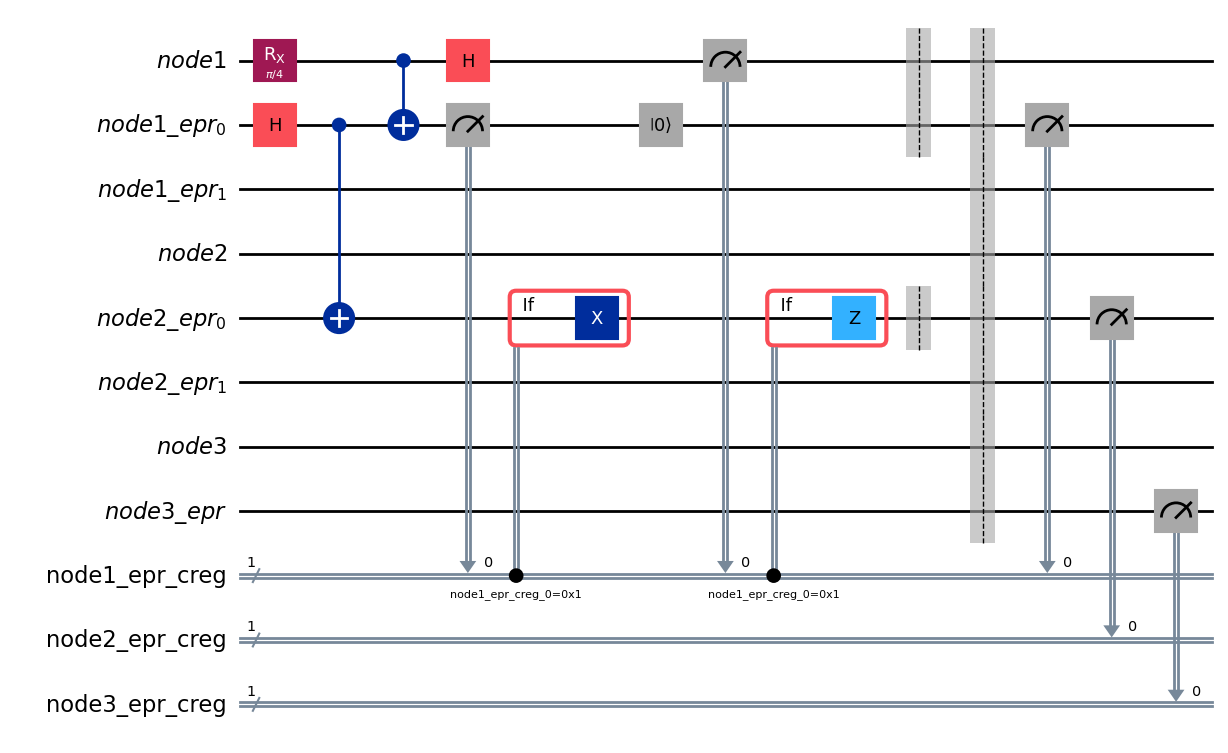

In [6]:
# # เผื่ออยากดูวงจร
sendqc_epr_class.q.draw('mpl')

In [7]:
sim = AerSimulator()
sendqc_ready2run = transpile(sendqc_epr_class.q, sim)
result = sim.run(sendqc_ready2run).result()
counts = result.get_counts()
beautifule_print_result(sendqc_epr_class.q, counts)
# print(counts)
## ถ้าใส่ add_register(c0,c1,c2) ผลลัพธ์จะเป็น 'c2, c1, c0'

prob_single_cbit(counts, target_index=1)

Classical registers (left→right): node3_epr_creg[1] → node2_epr_creg[1] → node1_epr_creg[1]

Counts:
0 1 0 : 140
0 0 0 : 884
P(cbit[1] = 0) = 0.8633
P(cbit[1] = 1) = 0.1367


In [8]:
# # build distributed circuit with N nodes and returns circuit with list of quantum registers
# def buildQMPI(N):
#     circ = QuantumCircuit() 
#     qrs = [] 
#     for i in range(N):
#         qr = QuantumRegister(1, name = 'q'+str(i))
#         circ.add_register(qr)
#         qrs.append(qr)
#     cr = ClassicalRegister(N,name = 'cr')
#     circ.add_register(cr)
#     return circ, qrs

# a,b = buildQMPI(4)

# This section is Collective Operation parts

In [9]:
for i in range(5):
    print(f"Smile{i}")

Smile0
Smile1
Smile2
Smile3
Smile4


In [10]:
collective_circuit = QuantumCircuit()
nodes_count = 5
qnode = {}
for i in range(nodes_count):
    qnode[i] = QuantumRegister(1, name = f"node{i}")
    collective_circuit.add_register(qnode[i])

In [11]:
# Initiate ให้ node1[0] มีโอกาส ket(0) ~85%
collective_circuit.rx(math.pi/4, qnode[0][0])   # หมุนแกน X มุม π/4 บน qubit 0

collective_class = MPI_collective.CollectiveMPI(collective_circuit)
# collective_class.q.draw('mpl')
# print(collective_class.length)

# Broadcast 
operation = collective_class.brodcast([qnode[0][0], qnode[1][0], qnode[2][0], qnode[3][0], qnode[4][0]])

# qdata_to_circuit(collective_class.q, operation)

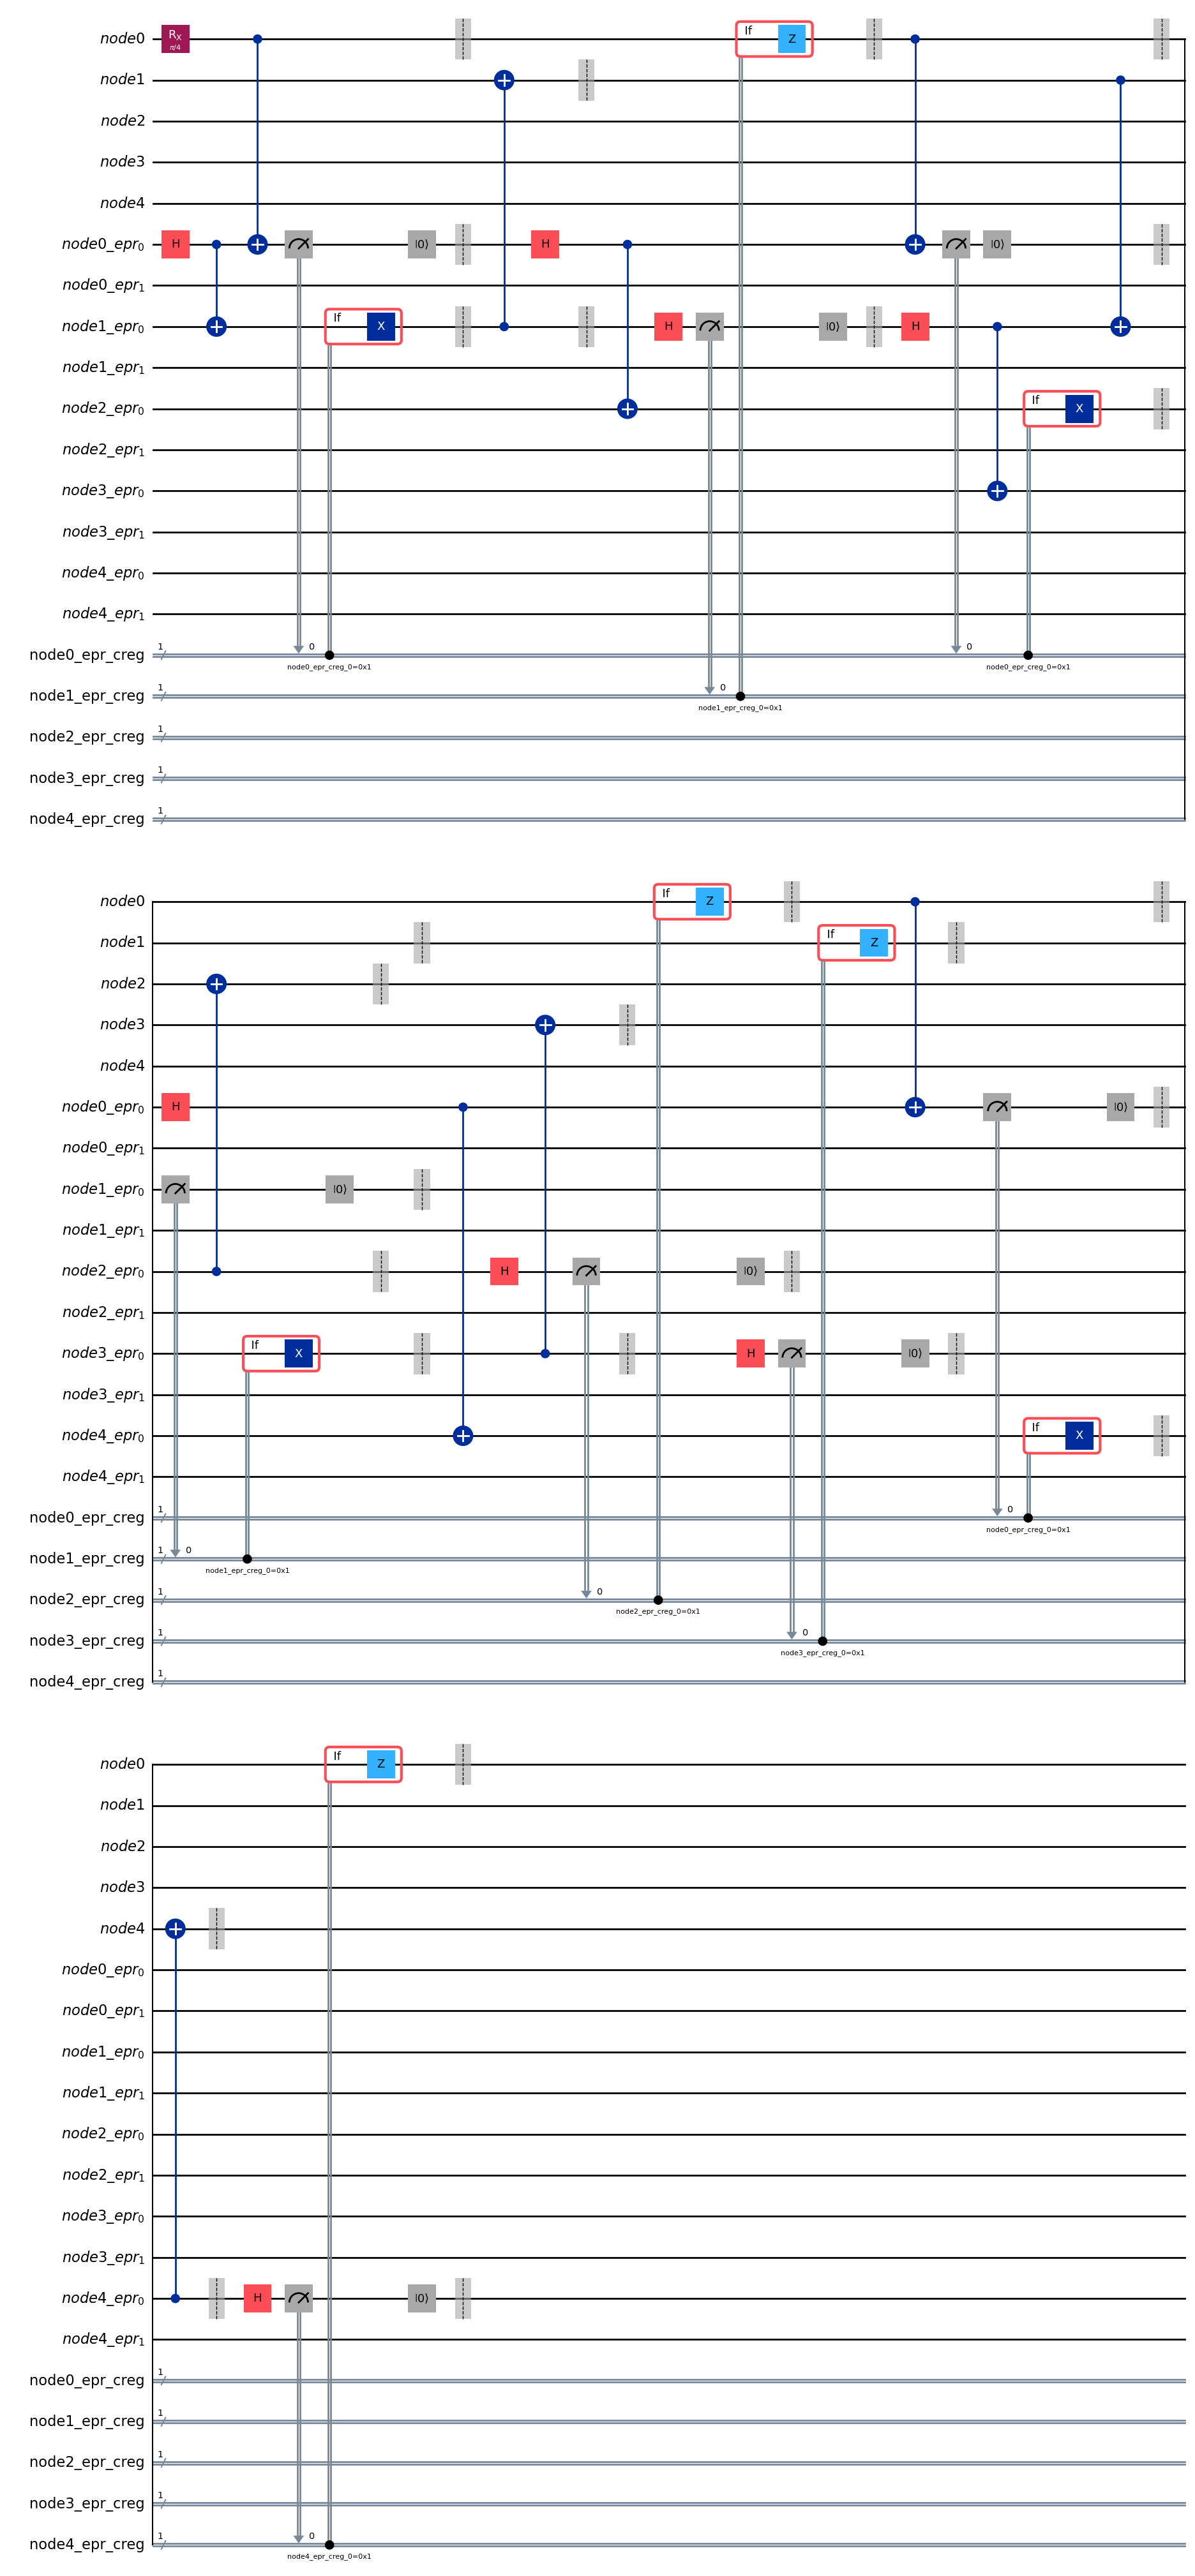

In [12]:
collective_class.q.draw('mpl')

In [13]:
sim = AerSimulator()
collective_ready2run = transpile(collective_class.q, sim)
result = sim.run(collective_ready2run).result()
counts = result.get_counts()
beautifule_print_result(collective_class.q, counts)
# print(counts)
## ถ้าใส่ add_register(c0,c1,c2) ผลลัพธ์จะเป็น 'c2, c1, c0'

prob_single_cbit(counts, target_index=0)

Classical registers (left→right): node4_epr_creg[1] → node3_epr_creg[1] → node2_epr_creg[1] → node1_epr_creg[1] → node0_epr_creg[1]

Counts:
1 0 1 0 1 : 36
1 0 0 0 0 : 38
1 1 1 0 1 : 26
1 1 0 1 0 : 33
1 0 0 0 1 : 34
0 0 1 0 1 : 30
0 1 0 0 1 : 31
0 1 1 0 1 : 40
0 1 0 1 1 : 27
0 0 0 1 1 : 18
0 0 1 1 1 : 39
1 1 1 1 0 : 34
0 0 1 0 0 : 32
1 1 0 0 0 : 26
0 1 0 1 0 : 33
0 0 0 0 0 : 26
1 1 0 0 1 : 33
0 1 1 1 1 : 34
0 0 0 1 0 : 40
0 1 1 1 0 : 23
1 1 1 0 0 : 32
0 0 1 1 0 : 35
0 0 0 0 1 : 34
1 0 1 0 0 : 26
1 0 1 1 1 : 36
1 0 0 1 0 : 31
1 1 1 1 1 : 28
1 1 0 1 1 : 28
1 0 1 1 0 : 34
1 0 0 1 1 : 44
0 1 0 0 0 : 29
0 1 1 0 0 : 34
P(cbit[0] = 0) = 0.4932
P(cbit[0] = 1) = 0.5068


In [176]:
collective_circuit_tinthai = QuantumCircuit()
node0 = QuantumRegister(1, name = "node0")
node0_epr = QuantumRegister(2, name = "node0_epr")
node0_epr_creg = ClassicalRegister(1, name = "node0_epr_creg")
node1 = QuantumRegister(1, name = "node1")
node1_epr = QuantumRegister(2, name = "node1_epr")
node1_epr_creg = ClassicalRegister(1, name = "node1_epr_creg")
node2 = QuantumRegister(1, name = "node2")
node2_epr = QuantumRegister(2, name = "node2_epr")
node2_epr_creg = ClassicalRegister(1, name = "node2_epr_creg")
node3 = QuantumRegister(1, name = "node3")
node3_epr = QuantumRegister(1, name = "node3_epr")
node3_epr_creg = ClassicalRegister(1, name = "node3_epr_creg")
epr_c = ClassicalRegister(2, name = "epr_cr")

collective_circuit_tinthai.add_register(node0,node0_epr,node1,node1_epr,node2,node2_epr,node3,node3_epr)
collective_circuit_tinthai.add_register(node0_epr_creg,node1_epr_creg,node2_epr_creg,node3_epr_creg)

# Initiate ให้ node1[0] มีโอกาส ket(0) ~85%
collective_circuit_tinthai.rx(math.pi/4, node0[0])   # หมุนแกน X มุม π/4 บน qubit 0
# ลองใช้ QMPI ของ Tom Nguyen ดู
collective_circuit_tinthai = MPI.EPRsetup(collective_circuit_tinthai, node0[0], node1[0])

# Send 
operation = collective_circuit_tinthai.send()
qdata_to_circuit(collective_circuit_tinthai.q, operation)

# Device setup
collective_circuit_tinthai.q.cx(node0_epr[0], node1_epr[0])
collective_circuit_tinthai.q.cx(node1_epr[0], node2_epr[0])
collective_circuit_tinthai.q.cx(node2_epr[0], node3_epr[0])

# # UnSend 
# operation = collective_circuit_tinthai.unsend()
# qdata_to_circuit(collective_circuit_tinthai.q, operation)

# Entanglement กลับ (ใช้แทน Teleportation จริงๆไปก่อน สมมติว่าเราเตรียม EPR pair ไว้แล้ว)
collective_circuit_tinthai.q.cx(node1_epr[0], node1[0])
collective_circuit_tinthai.q.cx(node2_epr[0], node2[0])
collective_circuit_tinthai.q.cx(node3_epr[0], node3[0])


# from qiskit import ClassicalRegister

# # เพิ่ม qubits กลาง (mid) สำหรับ GHZ entanglement
# collective_circuit_tinthai.q.add_register(
#     node1_mid := QuantumRegister(1, 'node1_mid'),
#     node2_mid := QuantumRegister(1, 'node2_mid'),
#     node3_mid := QuantumRegister(1, 'node3_mid')
# )

# # เพิ่ม classical registers สำหรับ measurement
# collective_circuit_tinthai.q.add_register(
#     c1 := ClassicalRegister(2, 'c1'),
#     c2 := ClassicalRegister(2, 'c2'),
#     c3 := ClassicalRegister(2, 'c3')
# )

# # ------------------------------------------------------
# # Step 1: สร้าง GHZ entanglement ระหว่าง mid qubits
# # ------------------------------------------------------
# q = collective_circuit_tinthai.q
# q.h(node1_mid[0])
# q.cx(node1_mid[0], node2_mid[0])
# q.cx(node2_mid[0], node3_mid[0])

# # ------------------------------------------------------
# # Step 2: ฟังก์ชัน teleportation (ใช้ if_test)
# # ------------------------------------------------------
# def teleport(q, src, entangled_qubit, dest, c):
#     q.cx(src, entangled_qubit)
#     q.h(src)
#     q.measure(src, c[0])
#     q.measure(entangled_qubit, c[1])

#     with q.if_test((c, 1)):
#         q.x(dest)
#     with q.if_test((c, 2)):
#         q.z(dest)
#     with q.if_test((c, 3)):
#         q.x(dest)
#         q.z(dest)

# # ------------------------------------------------------
# # Step 3: ทำ teleportation แทนการ cx เดิม
# # ------------------------------------------------------
# teleport(q, node1_epr[0], node1_mid[0], node1[0], c1)
# teleport(q, node2_epr[0], node2_mid[0], node2[0], c2)
# teleport(q, node3_epr[0], node3_mid[0], node3[0], c3)


# การวัดด้วยตัวเอง
collective_circuit_tinthai.q.barrier()
collective_circuit_tinthai.recieveEPR(collective_circuit_tinthai.q, node1[0], node1_epr_creg[0])
collective_circuit_tinthai.recieveEPR(collective_circuit_tinthai.q, node2[0], node2_epr_creg[0])
collective_circuit_tinthai.recieveEPR(collective_circuit_tinthai.q, node3[0], node3_epr_creg[0])

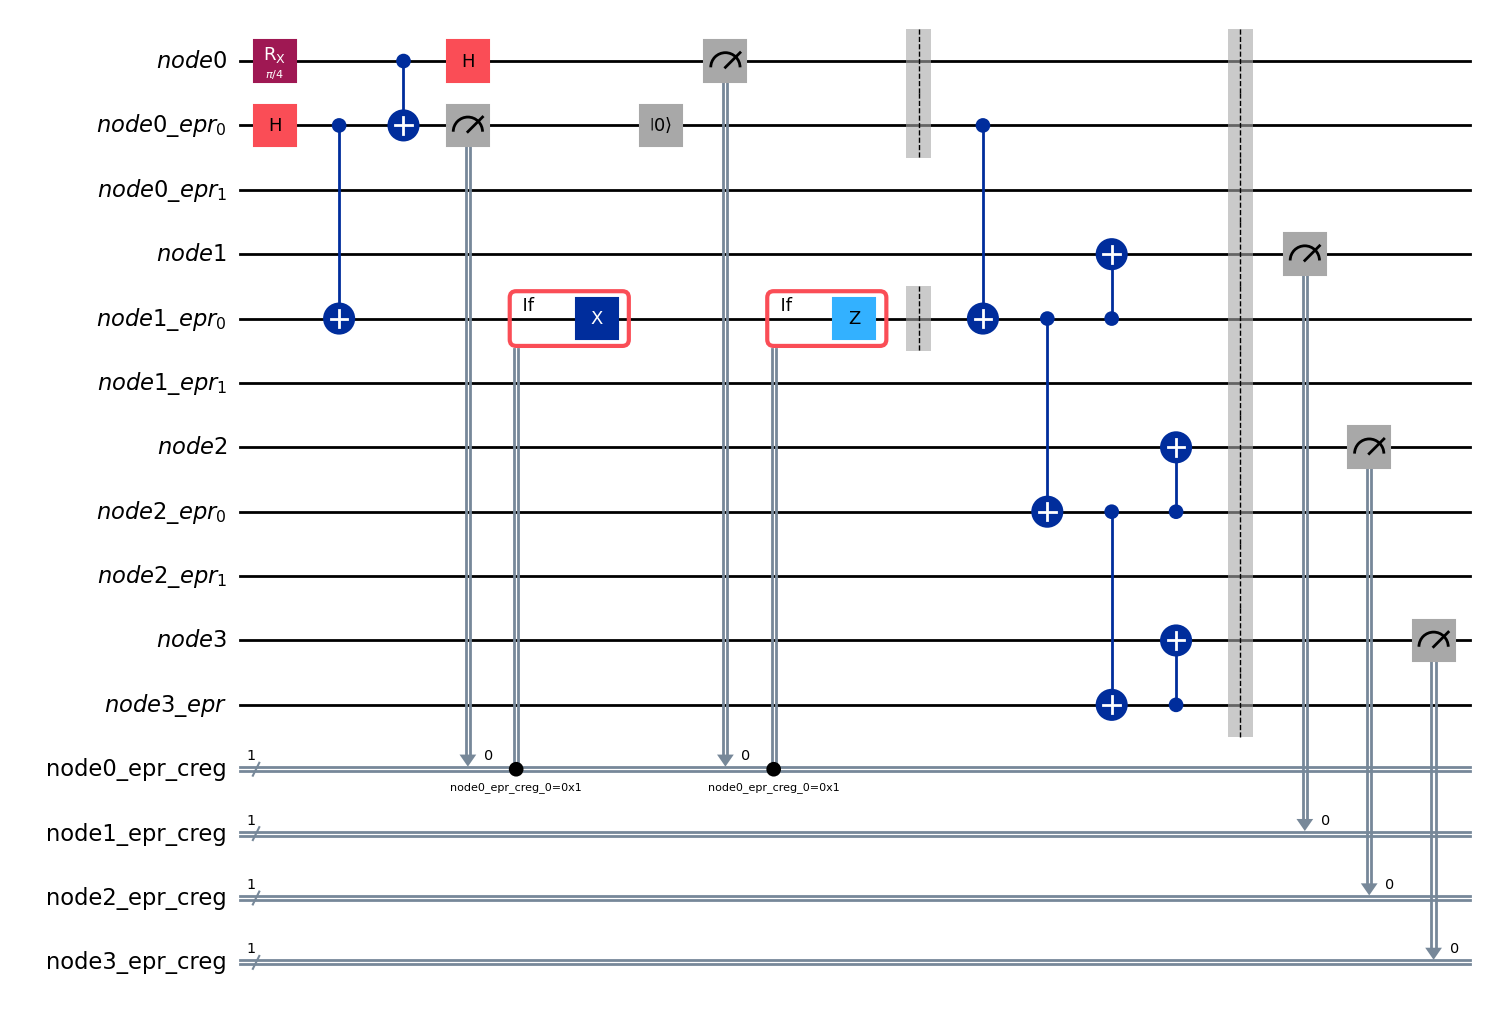

In [177]:
collective_circuit_tinthai.q.draw("mpl")

In [179]:
sim = AerSimulator()
collective_circuit_tinthai_ready2rn = transpile(collective_circuit_tinthai.q, sim)
result = sim.run(collective_circuit_tinthai_ready2rn).result()
counts = result.get_counts()
# beautifule_print_result(collective_circuit_tinthai.q, counts)
# print(counts)
## ถ้าใส่ add_register(c0,c1,c2) ผลลัพธ์จะเป็น 'c2, c1, c0'

print("Node 0 Prob:")
prob_single_cbit(counts, target_index=3)
print("")

print("Node 1 Prob:")
prob_single_cbit(counts, target_index=2)
print("")

print("Node 2 Prob:")
prob_single_cbit(counts, target_index=1)
print("")

print("Node 3 Prob:")
prob_single_cbit(counts, target_index=0)
print("")

Node 0 Prob:
P(cbit[3] = 0) = 0.4971
P(cbit[3] = 1) = 0.5029

Node 1 Prob:
P(cbit[2] = 0) = 0.8301
P(cbit[2] = 1) = 0.1699

Node 2 Prob:
P(cbit[1] = 0) = 0.8301
P(cbit[1] = 1) = 0.1699

Node 3 Prob:
P(cbit[0] = 0) = 0.8301
P(cbit[0] = 1) = 0.1699

